In [ ]:
# take two weeks, 1 with worms, 1 without
# check if there is some nocturnal rhythm (worms are more active at night)
# run model for each picture to count worms
# output images with contours and make sure it is counting the worms correctly
# compare the two weeks
# take in sensor data like temperature, humidity, soil humidity, etc
# check if there is a correlation between the sensor data and the number of worms
# run the above for multiple weeks

In [49]:
import os
import zipfile
from tempfile import TemporaryDirectory
from inference import get_model
from PIL import Image
import roboflow
import pandas as pd
import supervision as sv
from inference import get_model
from PIL.ImageFile import ImageFile
import cv2

In [4]:
model = get_model("wigglebin/2")

In [47]:
def analyze_image(image):
    results = model.infer(image)[0]
    return results

def draw_boxes(results, image_path, output_image_path):
    image = Image.open(image_path)
    image_np = np.array(image)  # Convert PIL image to NumPy array
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR

    # Convert the inference results to Supervisely format
    detections = sv.Detections.from_inference(results)

    # Create supervision annotators
    bounding_box_annotator = sv.BoxAnnotator()  # Set the color for bounding boxes
    label_annotator = sv.LabelAnnotator()  # Set the color for labels

    labels = [
        f"{model.class_names[class_id]} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    # Annotate the image with our inference results
    annotated_image_rgb = bounding_box_annotator.annotate(scene=image_bgr, detections=detections)
    annotated_image_bgr = label_annotator.annotate(scene=annotated_image_rgb, detections=detections, labels=labels)

        # Convert the annotated image back to RGB format
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
    annotated_image_pil = Image.fromarray(annotated_image_rgb)  # Convert NumPy array back to PIL image

    # Save the annotated image using PIL
    annotated_image_pil.save(output_image_path)

In [111]:
import numpy as np

# Define the folders containing the images
image_folders = [
    'downloads/daily/2024-09-02', 'downloads/daily/2024-09-03', 'downloads/daily/2024-09-04', 'downloads/daily/2024-09-05', 'downloads/daily/2024-09-06', 'downloads/daily/2024-09-07', 'downloads/daily/2024-09-08',  # week 36
    'downloads/daily/2024-09-09', 'downloads/daily/2024-09-10', 'downloads/daily/2024-09-11', 'downloads/daily/2024-09-12', 'downloads/daily/2024-09-13', 'downloads/daily/2024-09-14', 'downloads/daily/2024-09-15',  # week 37
    'downloads/daily/2024-09-16', 'downloads/daily/2024-09-17', 'downloads/daily/2024-09-18', 'downloads/daily/2024-09-19', 'downloads/daily/2024-09-20', 'downloads/daily/2024-09-21', 'downloads/daily/2024-09-22',  # week 38
    'downloads/daily/2024-09-23', 'downloads/daily/2024-09-23', 'downloads/daily/2024-09-25', 'downloads/daily/2024-09-26', 'downloads/daily/2024-09-27', 'downloads/daily/2024-09-28', 'downloads/daily/2024-09-29',  # week 39
]

all_results = []

# Loop over each folder
for folder in image_folders:
    # Loop over each image in the folder
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        
        # Open the image
        with Image.open(image_path) as img:
            # Analyze the image
            results = analyze_image(img)
            num_items_detected = len(results.predictions)

            # Append the image name and number of worms detected to the list
            all_results.append((image_name, image_path, results))


In [112]:
# show bounding boxes on the image
for (image_name, image_path, results) in all_results:
    draw_boxes(results, image_path, f"predictions/output/{image_name}")

In [114]:
data = []

# Loop over each image and its detection results
for (image_name, image_path, results) in all_results:
    worms_detected = [pred for pred in results.predictions if pred.class_name == 'worm']
    num_worms = len(worms_detected)
    
    # Extract date and time from image_name
    date_str = image_name.split('.')[0]
    date_time = pd.to_datetime(date_str, format='%Y-%m-%d-%H-%M')
    
    # Extract week number
    week_number = date_time.isocalendar().week
    
    data.append((image_name, num_worms, date_time, week_number))

# Create a DataFrame from the data
worms_detected_count = pd.DataFrame(data, columns=['image_name', 'num_worms', 'date_time', 'week_number'])

worms_detected_count = worms_detected_count.sort_values(by='date_time')
worms_detected_count

,image_name,num_worms,date_time,week_number
102,2024-09-02-00-00.jpg,3,2024-09-02 00:00:00,36
75,2024-09-02-00-10.jpg,2,2024-09-02 00:10:00,36
55,2024-09-02-00-20.jpg,2,2024-09-02 00:20:00,36
47,2024-09-02-00-30.jpg,1,2024-09-02 00:30:00,36
18,2024-09-02-00-40.jpg,2,2024-09-02 00:40:00,36
...,...,...,...,...
3918,2024-09-29-23-10.jpg,1,2024-09-29 23:10:00,39
4008,2024-09-29-23-20.jpg,1,2024-09-29 23:20:00,39
4023,2024-09-29-23-30.jpg,0,2024-09-29 23:30:00,39
3970,2024-09-29-23-40.jpg,0,2024-09-29 23:40:00,39


In [119]:
worms_detected_count.to_csv('./csv/worms_detected_count.csv', index=False)

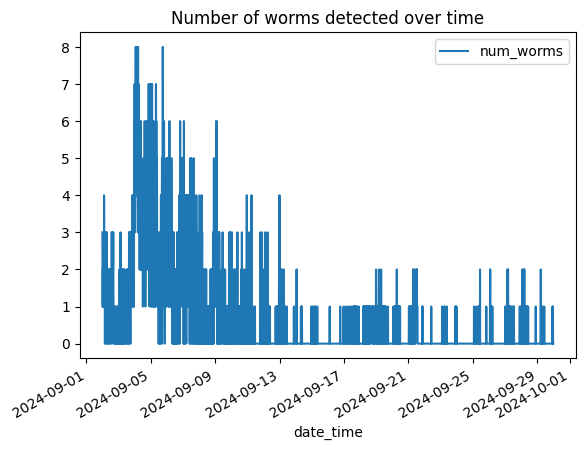

In [115]:
import matplotlib.pyplot as plt

worms_detected_count.plot(x='date_time', y='num_worms', kind='line', title='Number of worms detected over time')
plt.show()

## Nocturnal rhythm

Check if there is some nocturnal rhythm (worms are more active at night)

In [118]:
# TODO: Take out feeding days
# TODO: Take data from other weeks
# TODO: Check if it is a nocturnal rhythm of moisture related

In [116]:
worms_per_hour = worms_detected_count.resample('h', on='date_time').sum()

# Group by hour of the day and sum the number of worms detected
worms_per_hour['hour'] = worms_per_hour.index.hour
total_count_per_hour = worms_per_hour.groupby('hour')['num_worms'].sum().reset_index()

total_count_per_hour.head()

,hour,num_worms
0,0,147
1,1,170
2,2,172
3,3,130
4,4,141


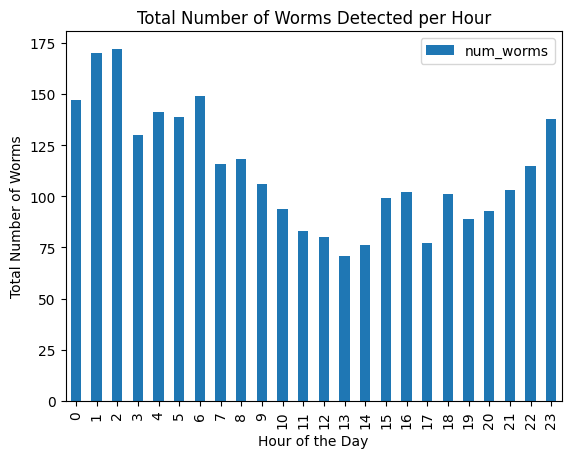

In [117]:
total_count_per_hour.plot(x='hour', y='num_worms', kind='bar', title='Total Number of Worms Detected per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Number of Worms')
plt.show()